### Score: `[54.5]`

Q1. `[5+5.5+5.5]` Good job!

Q2. `[11+11]` Great job!

Q3. `[5.5+11]` Very good job!

各题批注用`### Note`给出，请自行查阅。

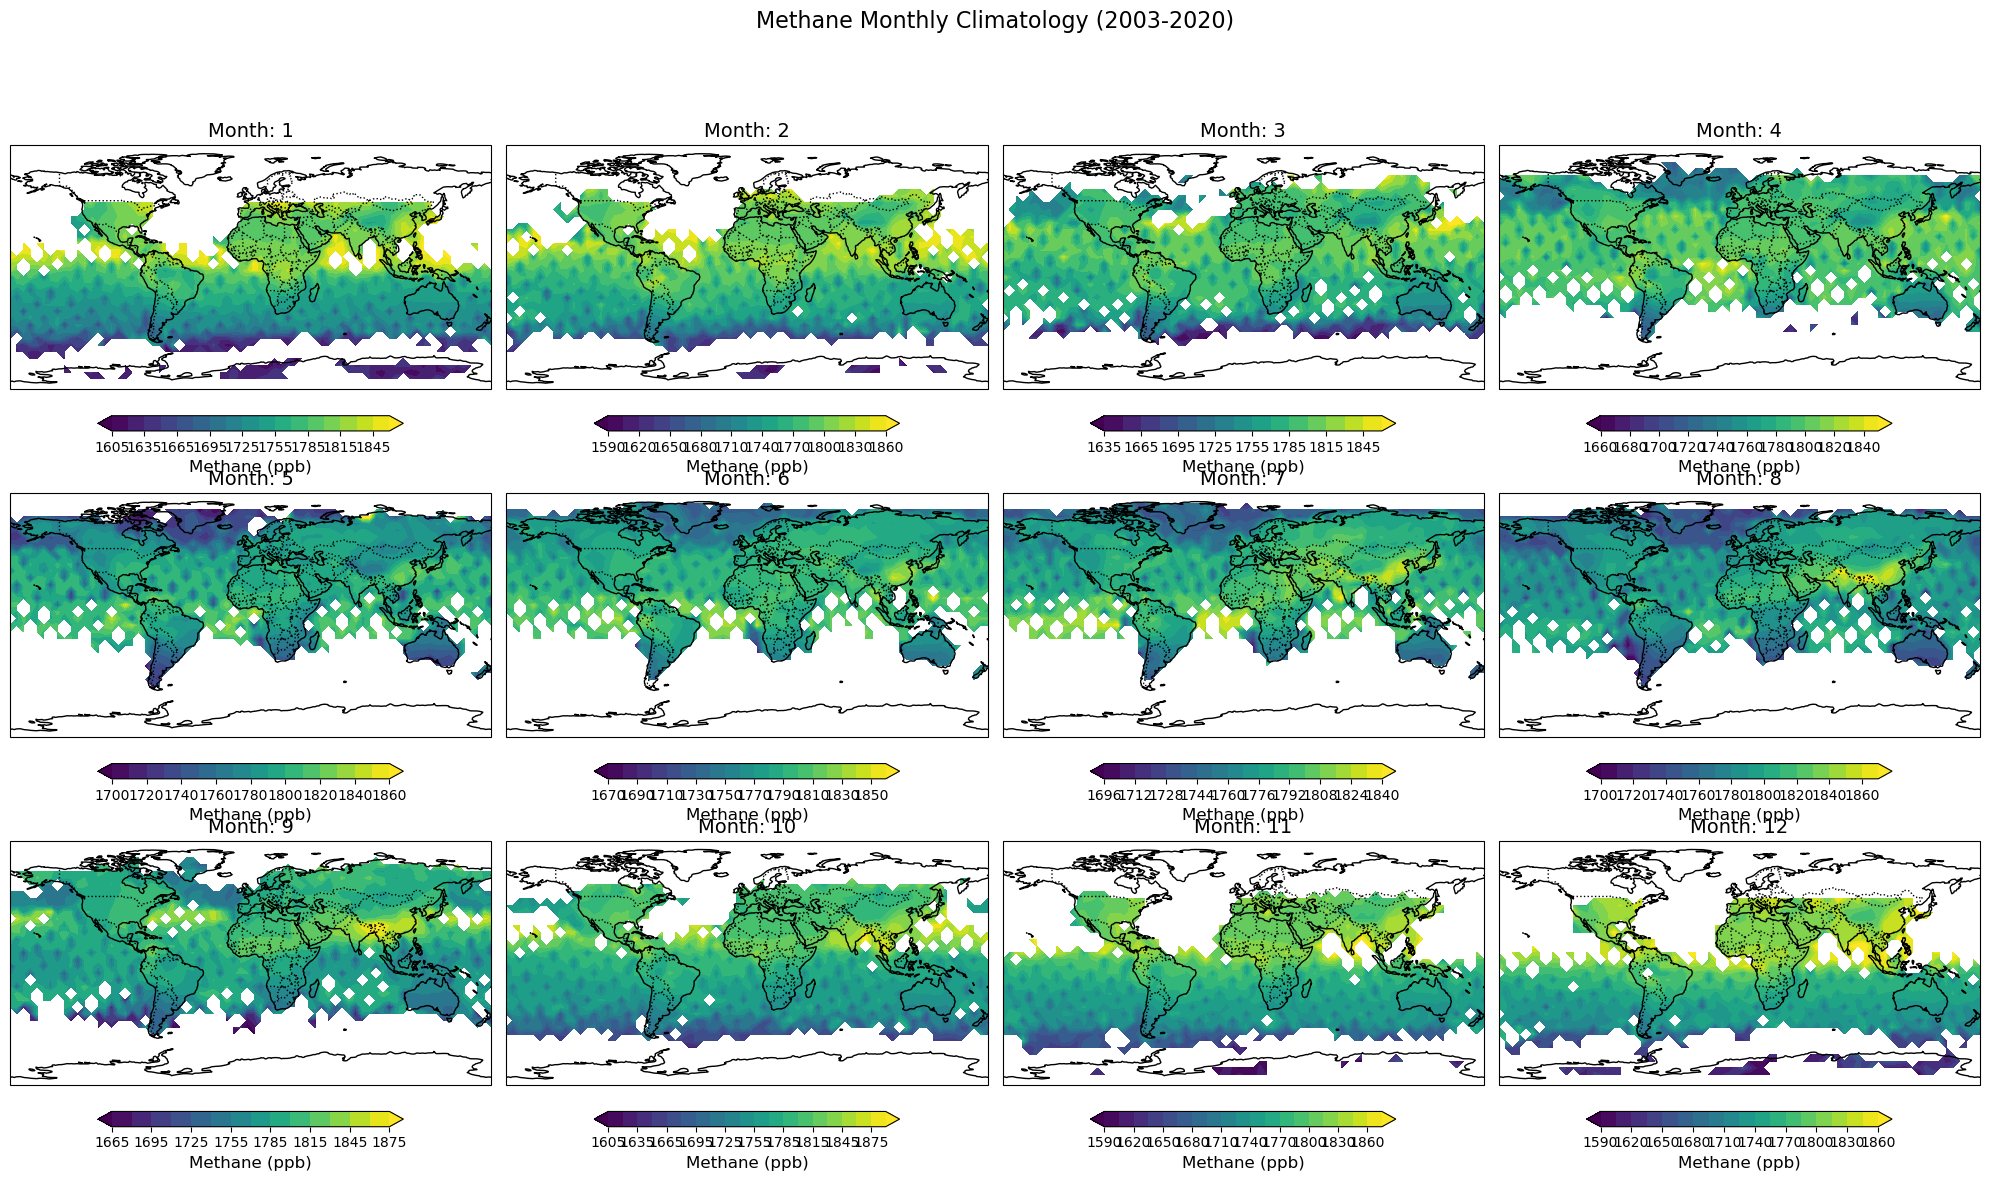

In [1]:
#1.1
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.signal import savgol_filter

# Load the netCDF file
file_path = "200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc"
data = xr.open_dataset(file_path)

# Extract variables
xch4 = data['xch4']  # Methane levels 
lat = data['lat']
lon = data['lon']
time = data['time']


# Convert time to datetime objects for easier handling
time = pd.to_datetime(time.values)

# Create an array to store climatology for each month (12 months)
monthly_climatology = []

# Compute climatology for each month (1-12)
for month in range(1, 13):
    # Select all data corresponding to the current month
    monthly_data = xch4.sel(time=xch4['time.month'] == month)
    # Convert methane data to ppb by multiplying by 10^9
    monthly_data_ppb = monthly_data * 1e9
    
    # Calculate the mean across all years for the current month
    climatology = monthly_data_ppb.mean(dim='time', skipna=True)
    monthly_climatology.append(climatology)

# Plotting the monthly climatology in a 3x4 grid
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('Methane Monthly Climatology (2003-2020)', fontsize=16)

# Define latitude and longitude grid for plotting
lons, lats = np.meshgrid(lon, lat)

# Iterate through each month and plot the corresponding climatology
for i, ax in enumerate(axes.ravel()):
    month_climatology = monthly_climatology[i]

    # Plot filled contours
    contour = ax.contourf(lons, lats, month_climatology, levels=20, cmap='viridis', extend='both')
    
    # Add features to the map
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(f'Month: {i+1}', fontsize=14)
    
    # Add colorbar
    cbar = fig.colorbar(contour, ax=ax, orientation='horizontal', fraction=0.046, pad=0.08)
    cbar.set_label('Methane (ppb)', fontsize=12)
    ### Note: colorbar标签再宽一点就更好看了

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


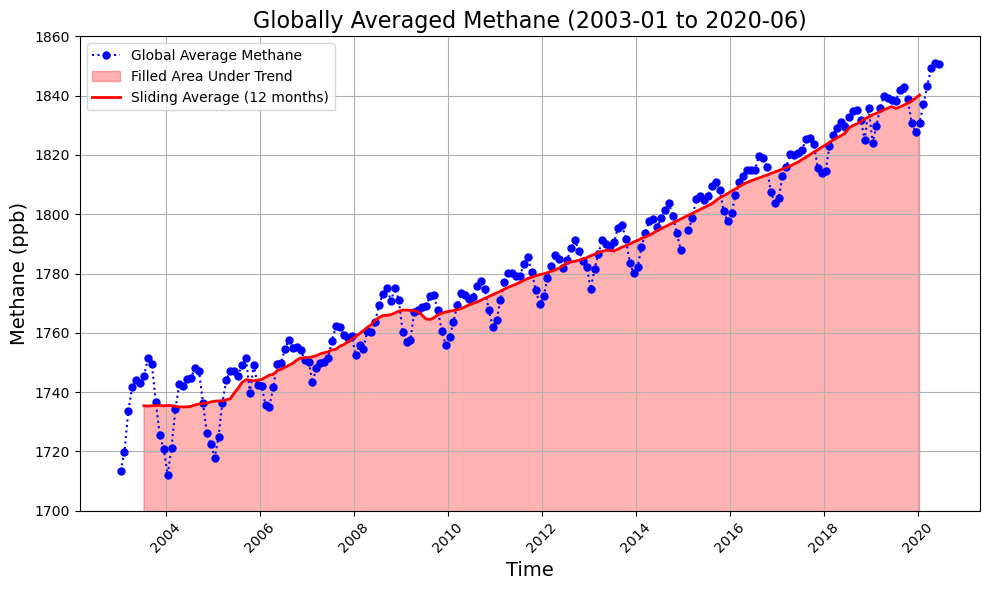

In [2]:
#1.2(sliding avg)
# Compute the globally averaged methane for each time step
# Convert methane data to ppb by multiplying by 10^9
xch4_ppb = xch4 * 1e9
# Calculate global mean methane concentrations
weights = np.cos(np.deg2rad(lat))  # Calculate area weights based on latitude
weights /= weights.sum()  # # Normalize the weights (sum should equal 1)

# Compute global mean
global_avg_xch4 = xch4_ppb.weighted(weights).mean(dim=['lat', 'lon'])

# Apply a rolling window to compute a moving average 
smoothed_trendline = global_avg_xch4.rolling(time=12, center=True).mean()



plt.figure(figsize=(10, 6))
plt.plot(time, global_avg_xch4, label='Global Average Methane', color='blue', marker='o', linestyle='dotted', markersize=5)
valid_indices = ~np.isnan(smoothed_trendline) # np.isnan() is a function of NumPy that checks if an element in an array is NaN
# Plot the globally averaged methane over time with the sliding average curve
smoothed_trendline = smoothed_trendline[valid_indices]
time_valid = time [valid_indices]
# Fill the area beneath the sliding average curve
plt.fill_between(time_valid, smoothed_trendline, color='red', alpha=0.3, label='Filled Area Under Trend')
plt.plot(time_valid, smoothed_trendline, label='Sliding Average (12 months)', color='red', linestyle='-', linewidth=2)
plt.title('Globally Averaged Methane (2003-01 to 2020-06)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Methane (ppb)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.ylim(1700, 1860)
plt.tight_layout()
plt.show()


#Methane concentrations show a seasonal trend with increasing concentrations as the year progresses. The trend line shows increasing concentrations with each passing year.





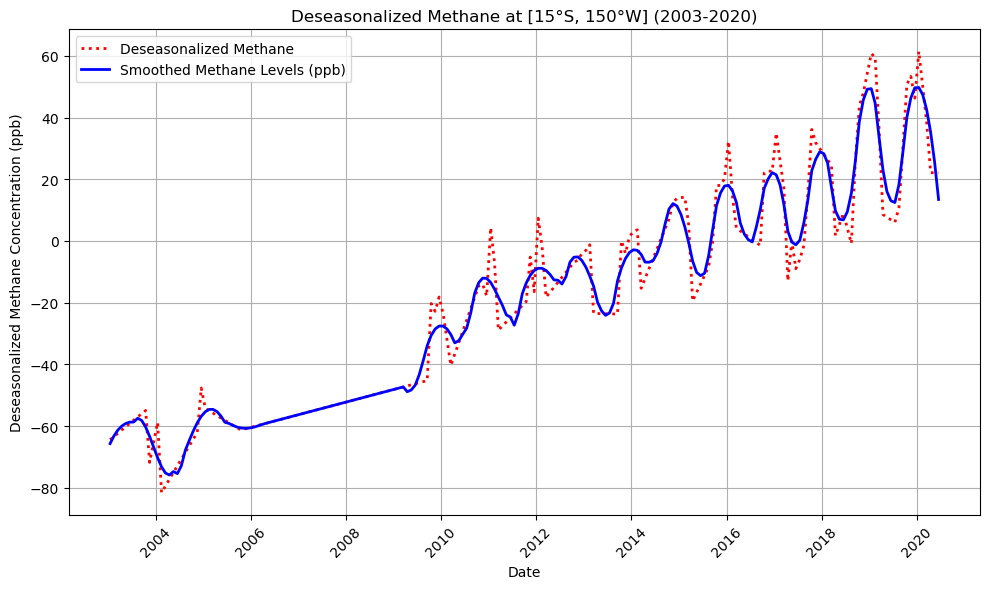

In [3]:
#1.3
# Define the target location (15°S, 150°W)
target_lat = -15
target_lon = -150

# Find the nearest latitude and longitude indices
lat_idx = np.argmin(np.abs(lat.values - target_lat))
lon_idx = np.argmin(np.abs(lon.values - target_lon))

# Extract the methane time series for the target location
methane_at_location = xch4_ppb[:, lat_idx, lon_idx]

# Detrend the methane series by removing the seasonal cycle
# Compute monthly climatology
monthly_climatology = methane_at_location.groupby('time.month').mean('time')

# Deseasonalize the series
deseasonalized_methane = methane_at_location.groupby('time.month') - monthly_climatology

# Handling NaN values: Fill NaN with linear interpolation
deseasonalized_methane_value = deseasonalized_methane.values
nans, x = np.isnan(deseasonalized_methane_value), lambda z: z.nonzero()[0]
deseasonalized_methane_value[nans] = np.interp(
    x(nans), x(~nans), deseasonalized_methane_value[~nans]
)

# Smooth the deseasonalized series using Savitzky-Golay filter
window_length = 13  # Window size
polyorder = 3       # Polynomial order
smoothed_series = savgol_filter(
    deseasonalized_methane_value, window_length=window_length, polyorder=polyorder, mode='interp'
)


# Plot the deseasonalized methane time series
plt.figure(figsize=(10, 6))
plt.plot(time, deseasonalized_methane_value, color='r', linestyle=':', linewidth=2, label='Deseasonalized Methane')  # Dotted line
plt.plot(time, smoothed_series, color='blue', linestyle='-', linewidth=2, label='Smoothed Methane Levels (ppb)')
plt.xlabel('Date')
plt.ylabel('Deseasonalized Methane Concentration (ppb)')
plt.title('Deseasonalized Methane at [15°S, 150°W] (2003-2020)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


#Slightly higher as the year increases, with little overall fluctuation in bias.

In [4]:
#2
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

# Function to open and read the NetCDF dataset
def open_netcdf(file_path):
    try:
        dataset = xr.open_dataset(file_path)
        return dataset
    except FileNotFoundError:
        print(f"File {file_path} not found.")
        return None

# Function to extract data from NetCDF dataset
def extract_data(dataset):
    # Extract variables for SST, time, latitude, and longitude
    sst = dataset.variables['sst'][:]  
    time = pd.to_datetime(dataset['time'].values)  # Convert time to pandas datetime
    lat = dataset.variables['lat'][:]  
    lon = dataset.variables['lon'][:]
    return sst, time, lat, lon

# Function to subset data for Niño 3.4 region (5N-5S, 170W-120W)
def subset_nino34_region(sst, lat, lon):
    # Define the bounds of the Niño 3.4 region
    lat_min, lat_max = -5, 5
    lon_min, lon_max = 190, 240 #170W - 120w = 190e - 240e

    # Find indices for these latitudes and longitudes
    lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]
    lon_indices = np.where((lon >= lon_min) & (lon <= lon_max))[0]

    # Subset the SST data for the Niño 3.4 region
    sst_nino34 = sst[:, lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]
    return sst_nino34, lat_indices, lon_indices

def calculate_climatology(sst_nino34_mean, time):
    # Calculate the 12-month SST climate average (climatology)
    # Extract months (1-12)
    months = time.month
    climatology = np.zeros(12)

    # Calculate the average of 57 years for each month separately
    for month in range(1, 13):
        climatology[month - 1] = sst_nino34_mean[months == month].mean()
    
    return climatology
    
def calculate_monthly_climatology(climatology):
    '''
    Calculate the sliding average for each month (3months_monthly_climatology)
    For January: average of January and February only;
    For December: average of November and December only;
    For other months: take the average of the current month, the previous month and the month after.
    '''
    monthly_climatology = np.zeros(12)
    
    # Processing January (average of January and February)
    monthly_climatology[0] = (climatology[0] + climatology[1]) / 2

    # Processing December (average of November and December)
    monthly_climatology[11] = (climatology[10] + climatology[11]) / 2

    # Other months processed (average of 3 months before and after)
    for month in range(1, 11):  
        monthly_climatology[month] = (
            climatology[month - 1] + climatology[month] + climatology[month + 1]
        ) / 3

    return monthly_climatology

def calculate_anomalies(sst_nino34_mean, time, monthly_climatology):
    #Calculate deviations (anomalies) between SST and monthly_climatology
    months = time.month
    anomalies = sst_nino34_mean.copy()

    # Calculating anomalies
    for i in range(len(sst_nino34_mean)):
        month = months[i] - 1   # Indexes corresponding to climatology (0-11)
        anomalies[i] = sst_nino34_mean[i] - monthly_climatology[month]
    
    return anomalies

file_path2='NOAA_NCDC_ERSST_v3b_SST.nc'
dataset = open_netcdf(file_path2)

sst, time, lat, lon = extract_data(dataset)

# Subset the data for the Niño 3.4 region
sst_nino34, lat_indices, lon_indices = subset_nino34_region(sst, lat, lon)
sst_nino34_mean = sst_nino34.mean(dim=["lat", "lon"])
# Calculate the monthly climatology
climatology = calculate_climatology(sst_nino34_mean, time)
monthly_climatology = calculate_monthly_climatology(climatology)
# Calculate SST anomalies
anomalies = calculate_anomalies(sst_nino34_mean, time, monthly_climatology)
# Print a summary of the results
print("Climatology (monthly mean SST):")
print(climatology)
print("\nMonthly Climatology (3-month moving average):")
print(monthly_climatology)
print("\nAnomalies (SST - Monthly Climatology):")
print(anomalies)

mean_anomaly = np.mean(anomalies)
std_anomaly = np.std(anomalies)
max_anomaly = np.max(anomalies)
min_anomaly = np.min(anomalies)

print("Anomalies Statistics Report:")
print(f"Mean Anomaly: {mean_anomaly:.4f} °C")
print(f"Standard Deviation: {std_anomaly:.4f} °C")
print(f"Max Anomaly: {max_anomaly:.4f} °C")
print(f"Min Anomaly: {min_anomaly:.4f} °C")
print("\nSample of Anomalies Values:")
print(anomalies[:12])  # Output anomalies as examples



Climatology (monthly mean SST):
[26.56811905 26.7426033  27.23990631 27.69402695 27.7955246  27.59806824
 27.19927216 26.82458115 26.73820114 26.71751404 26.69366646 26.613451  ]

Monthly Climatology (3-month moving average):
[26.65536118 26.85020955 27.22551219 27.57648595 27.69587326 27.530955
 27.20730718 26.92068481 26.76009878 26.71646055 26.67487717 26.65355873]

Anomalies (SST - Monthly Climatology):
<xarray.Variable (time: 684)>
array([-4.06822205e-01, -5.76127350e-01, -2.53758103e-01, -6.94249496e-02,
       -7.79476166e-02, -2.90577561e-01, -1.50004700e-01, -8.14456940e-02,
       -1.74115494e-01, -3.78810257e-01, -3.42103958e-01, -2.48806000e-01,
       -2.78715134e-01, -2.41889313e-01, -2.25981399e-01, -6.75843582e-02,
        1.51565552e-01,  3.06496948e-01, -7.83742294e-02, -5.14797211e-01,
       -8.00214112e-01, -7.91329682e-01, -4.77502823e-01, -4.57420349e-01,
       -5.32024384e-01, -5.63546479e-01, -4.21639115e-01, -3.49385589e-01,
       -4.64881897e-01, -3.5977235

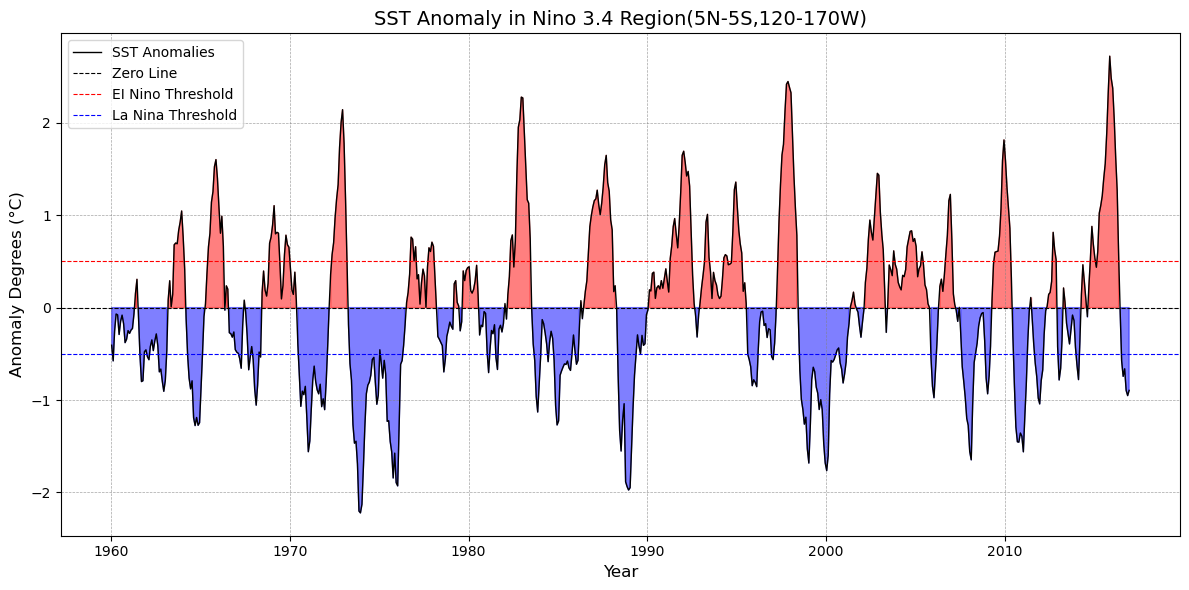

In [5]:
plt.figure(figsize=(12, 6))

# Plotting anomalies
plt.plot(time, anomalies, label="SST Anomalies", color="black", linewidth=1)

# Fill in parts greater than 0 (red) and parts less than 0 (blue)
plt.fill_between(time, anomalies, 0, where=(anomalies > 0), color="red", alpha=0.5)
plt.fill_between(time, anomalies, 0, where=(anomalies < 0), color="blue", alpha=0.5)

# Add auxiliary lines
plt.axhline(0, color="black", linestyle="--", linewidth=0.8, label="Zero Line")
plt.axhline(0.5, color="red", linestyle="--", linewidth=0.8, label="EI Nino Threshold")
plt.axhline(-0.5, color="blue", linestyle="--", linewidth=0.8, label="La Nina Threshold")

plt.title("SST Anomaly in Nino 3.4 Region(5N-5S,120-170W)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Anomaly Degrees (°C)", fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()

plt.show()

In [6]:
#netCDF file：TROPESS Chemical Reanalysis OH Monthly 3-dimensional Product V1 (TRPSCROHM3D)（2018-2021）
'''
https://send.cra.moe/file/QS0XIQZ1qficqnGO/kdUMnIKSoJcGyJIS/TROPESS_reanalysis_mon_oh_2018.nc
https://send.cra.moe/file/QS0XIQZ1qficqnGO/jtNehsccrdQbhvds/TROPESS_reanalysis_mon_oh_2019.nc
https://send.cra.moe/file/QS0XIQZ1qficqnGO/JvNtsyiwn6996YwK/TROPESS_reanalysis_mon_oh_2020.nc
https://send.cra.moe/file/QS0XIQZ1qficqnGO/XxVEyAB7yTrd7CRF/TROPESS_reanalysis_mon_oh_2021.nc
'''


'\nhttps://send.cra.moe/file/QS0XIQZ1qficqnGO/kdUMnIKSoJcGyJIS/TROPESS_reanalysis_mon_oh_2018.nc\nhttps://send.cra.moe/file/QS0XIQZ1qficqnGO/jtNehsccrdQbhvds/TROPESS_reanalysis_mon_oh_2019.nc\nhttps://send.cra.moe/file/QS0XIQZ1qficqnGO/JvNtsyiwn6996YwK/TROPESS_reanalysis_mon_oh_2020.nc\nhttps://send.cra.moe/file/QS0XIQZ1qficqnGO/XxVEyAB7yTrd7CRF/TROPESS_reanalysis_mon_oh_2021.nc\n'

<>:13: SyntaxWarning: invalid escape sequence '\E'
<>:14: SyntaxWarning: invalid escape sequence '\E'
<>:15: SyntaxWarning: invalid escape sequence '\E'
<>:16: SyntaxWarning: invalid escape sequence '\E'
<>:13: SyntaxWarning: invalid escape sequence '\E'
<>:14: SyntaxWarning: invalid escape sequence '\E'
<>:15: SyntaxWarning: invalid escape sequence '\E'
<>:16: SyntaxWarning: invalid escape sequence '\E'
C:\Users\zhangchen\AppData\Local\Temp\ipykernel_19916\1522552002.py:13: SyntaxWarning: invalid escape sequence '\E'
  file_path_2018= "D:\Ese5023\Test\Ges\TROPESS_reanalysis_mon_oh_2018.nc"#Tagret file
C:\Users\zhangchen\AppData\Local\Temp\ipykernel_19916\1522552002.py:14: SyntaxWarning: invalid escape sequence '\E'
  file_path_2019= "D:\Ese5023\Test\Ges\TROPESS_reanalysis_mon_oh_2019.nc"
C:\Users\zhangchen\AppData\Local\Temp\ipykernel_19916\1522552002.py:15: SyntaxWarning: invalid escape sequence '\E'
  file_path_2020 ="D:\Ese5023\Test\Ges\TROPESS_reanalysis_mon_oh_2020.nc"
C:\Users\z

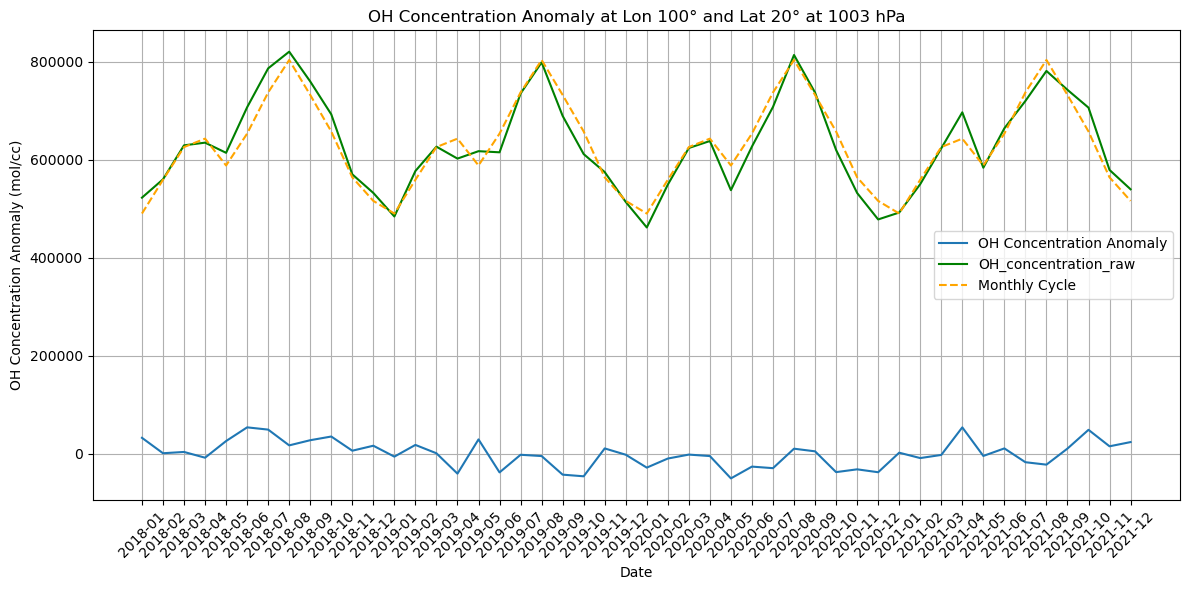

In [7]:
#3.1
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
from mpl_toolkits.mplot3d import Axes3D


# Load the netCDF file
file_path_2018= "D:\Ese5023\Test\Ges\TROPESS_reanalysis_mon_oh_2018.nc"#Tagret file
file_path_2019= "D:\Ese5023\Test\Ges\TROPESS_reanalysis_mon_oh_2019.nc"
file_path_2020 ="D:\Ese5023\Test\Ges\TROPESS_reanalysis_mon_oh_2020.nc"
file_path_2021 ="D:\Ese5023\Test\Ges\TROPESS_reanalysis_mon_oh_2021.nc"
data_2018 = xr.open_dataset(file_path_2018,decode_times=False)
data_2019 = xr.open_dataset(file_path_2019,decode_times=False)
data_2020 = xr.open_dataset(file_path_2020,decode_times=False)
data_2021 = xr.open_dataset(file_path_2021,decode_times=False)

# Merge data
data_all = xr.concat([data_2018, data_2019, data_2020, data_2021], dim='time')


# Convert 'time' to date format
time_units = data_all['time'].attrs['units']  # Access to time units
time_origin = time_units.split(' since ')[1]  # Start date of withdrawal (2005-01-01)
dates = cftime.num2date(data_all['time'].values, units=time_units, calendar='gregorian')  # Date of commencement of withdrawal (2005-01-01)

# Select specific lev layer (lev=60hpa) (top)
data_all_at_lev = data_all.sel(lev=60, method='nearest')

# Calculate monthly seasonal cycles
# Convert dates to months (1-12)
months = [date.month for date in dates]
data_all_at_lev['month'] = ('time', months)

# Calculate monthly seasonal cycles
monthly_cycle = data_all_at_lev.groupby('month').mean(dim='time')

# Remove monthly seasonal cycles from raw data
anomaly = data_all_at_lev - monthly_cycle.sel(month=data_all_at_lev['month'])

# Extract OH concentrations after removing seasonal variations and plot time series
# Select latitude and longitude points of interest, e.g. 100° longitude, 20° latitude
lon_index = np.abs(data_all_at_lev['lon'] - 100).argmin()  # Find the index closest to 100° longitude
lat_index = np.abs(data_all_at_lev['lat'] - 20).argmin()  


# Obtain OH concentration data after removing seasonal cycles
oh_concentration_anomaly = anomaly['oh'].isel(lon=lon_index, lat=lat_index)
# Raw OH concentration data obtained (seasonal cycle not removed)
oh_concentration_raw = data_all_at_lev['oh'].isel(lon=lon_index, lat=lat_index)

# Extract the year and month
# Get the combination of year and month
year_month = [f'{date.year}-{date.month:02d}' for date in dates]

# Create drawings
plt.figure(figsize=(12, 6))

# Plotting time series
plt.plot(year_month, oh_concentration_anomaly.values, label='OH Concentration Anomaly')

# Plotting raw data
plt.plot(year_month, oh_concentration_raw, label='OH_concentration_raw', linestyle='-', color='green')

# Calculate the monthly seasonal cycle at this latitude and longitude.
monthly_cycle_at_point = monthly_cycle['oh'].isel(lon=lon_index, lat=lat_index)

# Extend `monthly_cycle_at_point` to be the same length as `year_month` (48 months)
monthly_cycle_repeated = np.tile(monthly_cycle_at_point.values, 4)



# Mapping monthly seasonal cycles
plt.plot(year_month, monthly_cycle_repeated, label='Monthly Cycle', linestyle='--', color='orange')



# Setting up graphics
plt.xlabel('Date')
plt.ylabel('OH Concentration Anomaly (mol/cc)')
plt.title('OH Concentration Anomaly at Lon 100° and Lat 20° at 1003 hPa')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


[1000.  995.  980.  950.  900.  850.  800.  750.  700.  650.  600.  550.
  500.  450.  400.  350.  300.  250.  200.  175.  150.  125.  100.   90.
   80.   70.   60.]


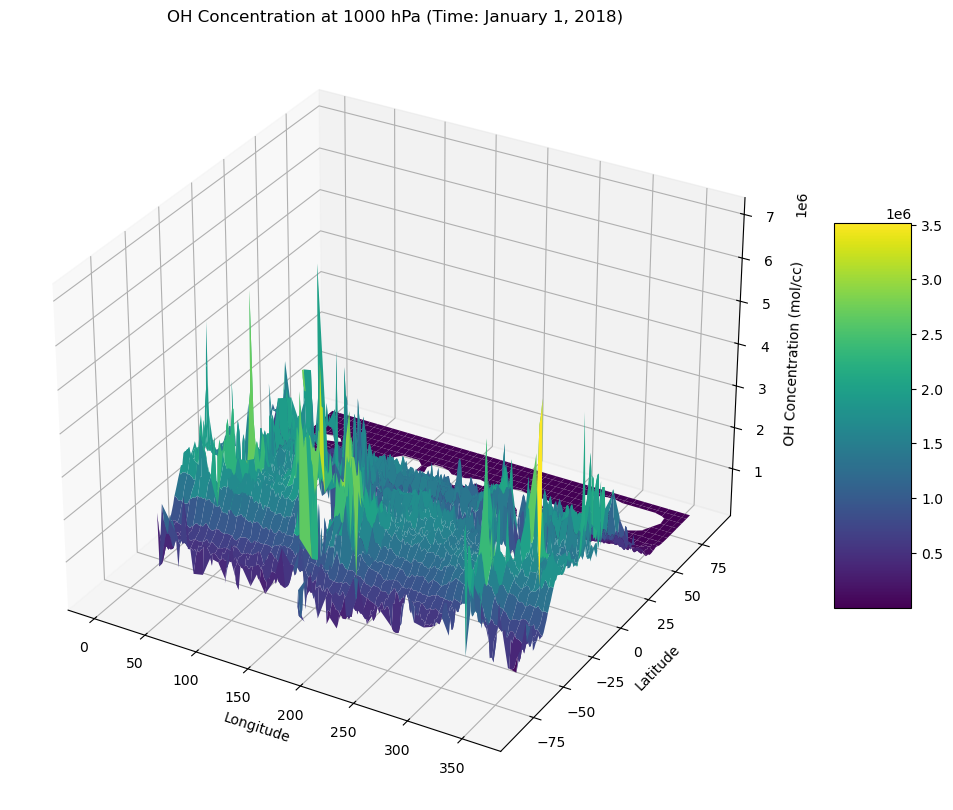

In [8]:
#3.2

# Fig.1: Distribution of OH concentration at a specific time and 1000 hPa pressure level across different latitudes and longitudes

# Select a specific time point
time_index = 0  # Select January 1, 2018 (modify this to another time point)
oh_at_time = data_all.isel(time=time_index)['oh']  # Extract OH concentration data

# Get grid data for longitude, latitude, and pressure levels
lon = oh_at_time['lon'].values
lat = oh_at_time['lat'].values
lev = oh_at_time['lev'].values
print(lev)

# Select a specific pressure level (e.g., 1000 hPa)
selected_lev = 1000  # Selected pressure level
oh_at_selected_lev = oh_at_time.sel(lev=selected_lev)  # Get OH concentration data at the selected pressure level

# Convert OH concentration data to a 2D array (corresponding to latitude and longitude at this pressure level)
oh_data = oh_at_selected_lev.values

# Create a grid (used for plotting the 3D surface)
Lon, Lat = np.meshgrid(lon, lat)

# Set up the plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D surface: X is longitude, Y is latitude, Z is OH concentration
surf = ax.plot_surface(Lon, Lat, oh_data, cmap='viridis', edgecolor='none')

# Add title and labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('OH Concentration (mol/cc)')
ax.set_title(f"OH Concentration at {selected_lev} hPa (Time: January 1, 2018)")

# Add color bar
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


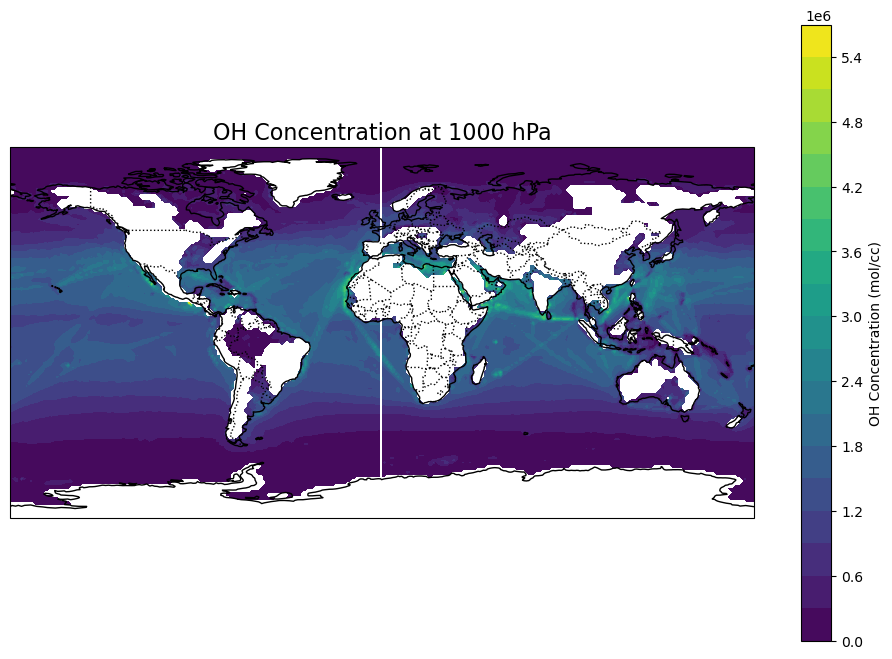

In [9]:
# Fig.2: Distribution of average OH concentration at 1000 hPa over four years

# Select OH concentration data at 1000 hPa and calculate the 4-year average
oh_at_1000hPa = data_all.sel(lev=1000)['oh'].mean(dim='time')  # Average over time

# Create a map
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_title('OH Concentration at 1000 hPa', fontsize=16)

# Draw coastlines and country borders
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the distribution of OH concentration
contour = ax.contourf(
    oh_at_1000hPa['lon'], 
    oh_at_1000hPa['lat'], 
    oh_at_1000hPa, 
    20, 
    transform=ccrs.PlateCarree(), 
    cmap='viridis'
)
plt.colorbar(contour, ax=ax, orientation='vertical', label='OH Concentration (mol/cc)')

plt.show()


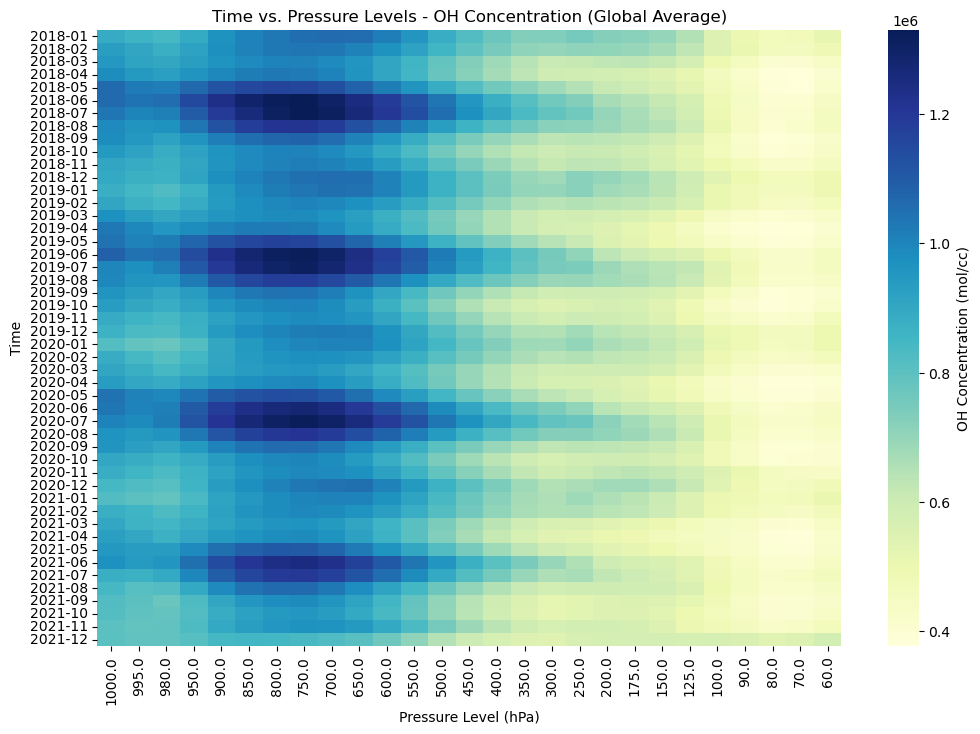

In [10]:
import seaborn as sns

# Fig.3: Time vs. pressure levels of OH concentration (global average without considering projection area)

# Select OH concentration data
oh_at_time = data_all['oh']  # Shape: (time, lon, lat, lev)

# Calculate the global average of OH concentration for each time point
# Average across latitude, longitude, and pressure level dimensions
oh_data_avg = oh_at_time.mean(dim=('lon', 'lat'))

# Extract OH concentration, pressure levels, and time data
oh_concentration_mean = oh_data_avg.values  # OH concentration, shape: (time, lev)
lev = oh_data_avg['lev'].values  # Pressure levels
time = data_all['time'].values  # Time data

# Create a 2D matrix of OH concentration: time x pressure level
heatmap_data = oh_concentration_mean

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data, 
    cmap='YlGnBu', 
    annot=False, 
    cbar_kws={'label': 'OH Concentration (mol/cc)'}, 
    xticklabels=lev, 
    yticklabels=year_month  
)

# Set title and axis labels
plt.title("Time vs. Pressure Levels - OH Concentration (Global Average)")
plt.xlabel('Pressure Level (hPa)')
plt.ylabel('Time')

plt.show()


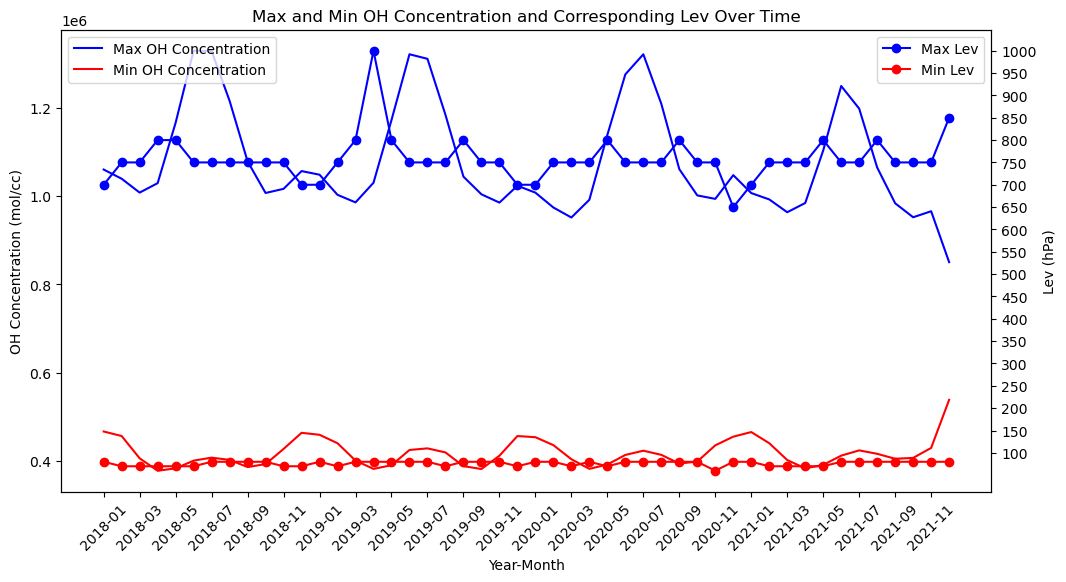

In [11]:
# Fig.4: Distribution of maximum and minimum OH concentrations, and their corresponding lev over time for different months and pressure levels

# Initialize lists to store maximum and minimum values
max_values = []
min_values = []
max_levs = []
min_levs = []

# Loop through each month, compute the maximum and minimum values, and record the corresponding lev
for time_idx in range(len(oh_data_avg.time)):
    # Compute maximum and minimum values for the month
    max_value = oh_data_avg.isel(time=time_idx).max(dim='lev')
    min_value = oh_data_avg.isel(time=time_idx).min(dim='lev')

    # Record the maximum and minimum values
    max_values.append(max_value.values)
    min_values.append(min_value.values)

    # Record the corresponding lev (i.e., the lev index of the maximum and minimum values)
    max_lev_idx = np.argmax(oh_data_avg.isel(time=time_idx).values, axis=0)
    min_lev_idx = np.argmin(oh_data_avg.isel(time=time_idx).values, axis=0)

    max_levs.append(oh_data_avg.lev[max_lev_idx].values)
    min_levs.append(oh_data_avg.lev[min_lev_idx].values)

# Convert to DataFrame for easier plotting
max_values = np.array(max_values)
min_values = np.array(min_values)
max_levs = np.array(max_levs)
min_levs = np.array(min_levs)

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the maximum and minimum concentration curves
ax1.plot(year_month, max_values, label='Max OH Concentration', color='blue')
ax1.plot(year_month, min_values, label='Min OH Concentration', color='red')

# Set left y-axis labels
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('OH Concentration (mol/cc)')
ax1.set_title('Max and Min OH Concentration and Corresponding Lev Over Time')
ax1.legend(loc='upper left')

# Create a secondary y-axis (right side)
ax2 = ax1.twinx()
# Plot the lev values for max and min OH concentrations
ax2.plot(year_month, max_levs, label='Max Lev', linestyle='-', marker='o', color='blue')
ax2.plot(year_month, min_levs, label='Min Lev', linestyle='-', marker='o', color='red')

# Set the right y-axis label
ax2.set_ylabel('Lev (hPa)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Adjust the right y-axis ticks to be in intervals of 50 hPa
lev_ticks = np.arange(1000, 50, -50)  # From 1000 to 50 with intervals of 50
ax2.set_yticks(lev_ticks)  # Set the y-axis ticks

# Display x-axis labels every 6 months and rotate them
ax1.set_xticks(year_month[::2])  # Display one label every 6 months
ax1.set_xticklabels(year_month[::2], rotation=45)  # Rotate labels by 45 degrees

# Set legend positions to avoid overlap
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust layout to avoid overlap of x-axis labels
# plt.tight_layout()

# Show the plot
plt.show()


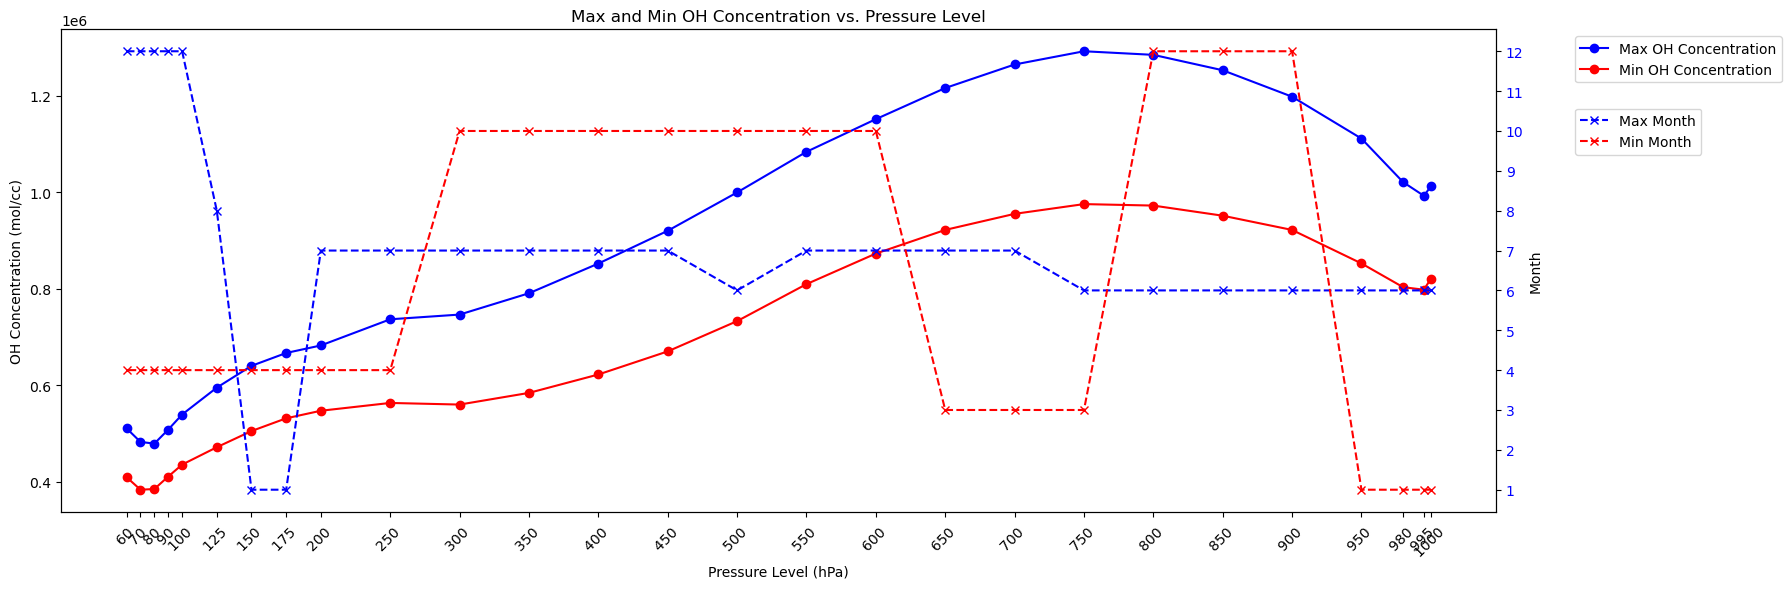

In [12]:
# Fig.5: Distribution of maximum and minimum OH concentrations with pressure level (lev) across different months

# Add a 'month' dimension based on time
data_all['month'] = ('time', months)  # `months` should be a pre-defined array with month indices (1 to 12)

# Group the data by month and calculate the average across time
monthly_data = data_all.groupby('month').mean(dim='time')

# Initialize lists to store results
max_values = []
min_values = []
max_months = []
min_months = []

# Loop through each pressure level (lev)
for lev_idx in range(len(data_all.lev)):
    # Extract OH concentration data for the current lev
    oh_at_lev = monthly_data['oh'].isel(lev=lev_idx)
    
    # Compute the mean across latitude and longitude
    oh_avg = oh_at_lev.mean(dim=('lat', 'lon'))
    
    # Find the maximum and minimum values for each month
    max_value = oh_avg.max()
    min_value = oh_avg.min()
    
    # Find the indices of the maximum and minimum values
    max_time_idx = oh_avg.argmax()
    min_time_idx = oh_avg.argmin()

    # Get the corresponding month for max and min values
    max_month = oh_at_lev.month[max_time_idx].values
    min_month = oh_at_lev.month[min_time_idx].values
    
    # Store the results
    max_values.append(max_value.values)
    min_values.append(min_value.values)
    max_months.append(max_month)
    min_months.append(min_month)

# Convert results to numpy arrays for easier plotting
max_values = np.array(max_values)
min_values = np.array(min_values)
max_months = np.array(max_months)
min_months = np.array(min_months)

# Plotting
fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot the maximum and minimum OH concentrations
ax1.plot(data_all.lev, max_values, label='Max OH Concentration', color='blue', marker='o')
ax1.plot(data_all.lev, min_values, label='Min OH Concentration', color='red', marker='o')

# Configure the left y-axis
ax1.set_xlabel('Pressure Level (hPa)')
ax1.set_ylabel('OH Concentration (mol/cc)')
ax1.set_title('Max and Min OH Concentration vs. Pressure Level')
ax1.legend(loc='upper left')

# Create a secondary y-axis for months
ax2 = ax1.twinx()

# Plot the months corresponding to max and min OH concentrations
ax2.plot(data_all.lev, max_months, label='Max Month', color='blue', linestyle='--', marker='x')
ax2.plot(data_all.lev, min_months, label='Min Month', color='red', linestyle='--', marker='x')

# Configure the right y-axis
ax2.set_ylabel('Month', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set right y-axis ticks to represent months
ax2.set_yticks(range(1, 13))  # Represent months from 1 to 12
ax2.set_yticklabels([str(i) for i in range(1, 13)], color='blue')  # Label ticks as months 1–12

# Configure the x-axis labels and rotate them
ax1.set_xticks(data_all.lev)
ax1.set_xticklabels([f'{int(lev)} ' for lev in data_all.lev], rotation=45)

# Adjust legends to avoid overlapping
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1))  # Place left legend outside the plot
ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 0.85))  # Place right legend below the left one

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Display the plot
plt.show()
